In [1]:
cd D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl

D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl


In [2]:
import torch
from torch import nn
import numpy as np
from architectures import encoders, decoders
from common.ops import Flatten3D, Unsqueeze3D, Reshape
from torch.nn import functional as F
import pickle
from common import dag_utils

# Multiscale + GNN structure test 

In [ ]:
cd D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl

## Testing Prior GNN

In [23]:
class SimpleGNNLayer(nn.Module):
    """
    Can be used to implement GNNs for P(Z|epsilon, A) or Q(Z|X,A)
    """
    def __init__(self, in_node_feat_dim, out_node_feat_dim, adj_mat, is_final_layer=False):
        super().__init__()

        self.in_node_feat_dim = in_node_feat_dim
        self.out_node_feat_dim = out_node_feat_dim
        self.is_final_layer = is_final_layer
        self.A = adj_mat.T # TODO:

        self.num_neighbours = self.A.sum(dim=-1, keepdims=True)
        self.projection = nn.Linear(self.in_node_feat_dim, self.out_node_feat_dim)
    
    def forward(self, node_feats):
        
        self.A = self.A.to(node_feats.device)
        self.num_neighbours = self.num_neighbours.to(node_feats.device)
        
        node_feats = self.projection(node_feats)
        #print(node_feats)
        node_feats = torch.matmul(self.A, node_feats)
        #print(node_feats)
        node_feats = node_feats / self.num_neighbours
        #print(node_feats)
        
        if self.is_final_layer:
            # split into mu and sigma
            node_feats_mu, node_feats_logvar = node_feats.chunk(2, dim=2)
            return node_feats_mu, node_feats_logvar
        else:
            node_feats = torch.tanh(node_feats)
            return node_feats

In [24]:
#from common.special_modules import SimpleGNNLayer

# V, ifd, ofd =5, 2, 4

# #inp = torch.randn(size=(1, V, ifd))

# inp = torch.arange(10).type(torch.FloatTensor).view(1, V, ifd)
# print(inp)
# print("input shape: ", inp.shape)

# prior_gnn = SimpleGNNLayer(ifd, ofd, A.T, is_final_layer=True)
# print("Linear layer mat shape: ", prior_gnn.projection.weight.data.shape)
# prior_gnn.projection.weight.data = torch.Tensor(
#         [[1., 0.],
#         [0., 1.],
#         [1., 0.],
#         [0., 1.]]
# )
# prior_gnn.projection.bias.data = torch.zeros(ofd)
# print("input: ", inp)
# out = prior_gnn(inp)
# print(out)


In [25]:
A_list = pickle.load(open(r"D:\Saarbrucken\EDA_Research\vae-disentanglement\adjacency_matrices\dsprites_correlated.pkl", 'rb'))
A = dag_utils.get_adj_mat_from_adj_list(A_list)
print(A)

prior_gnn = nn.Sequential(
            SimpleGNNLayer(4, 4, A),
            SimpleGNNLayer(4, 4, A),
            SimpleGNNLayer(4, 4, A, is_final_layer=True)
        )

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])


In [26]:
test_inp = torch.randn(size=(2, 5, 4))

probe_mu, probe_logvar = prior_gnn(test_inp)

In [27]:
print(probe_mu)
print(probe_logvar)

tensor([[[-0.4075, -0.1486],
         [-0.2652,  0.1489],
         [-0.2306,  0.0602],
         [-0.2523,  0.0454],
         [-0.2455,  0.0648]],

        [[-0.2006,  0.2517],
         [-0.2900,  0.1959],
         [-0.3454, -0.0522],
         [-0.3360, -0.0400],
         [-0.2233,  0.2115]]], grad_fn=<SplitBackward>)
tensor([[[ 0.4505, -0.4240],
         [ 0.3399, -0.3789],
         [ 0.4070, -0.3701],
         [ 0.4078, -0.3717],
         [ 0.4109, -0.3973]],

        [[ 0.2704, -0.2927],
         [ 0.2392, -0.3045],
         [ 0.4261, -0.3869],
         [ 0.4224, -0.3817],
         [ 0.3103, -0.3535]]], grad_fn=<SplitBackward>)


# Load model and test prior components

In [3]:
from gnncsvae_experiment import GNNCSVAEExperiment
from collections import defaultdict, namedtuple
import models
from common.notebook_utils import get_configured_dataset
from torch.utils.data import DataLoader
import os


ModelParams = namedtuple('ModelParams', ["z_dim", "l_dim", "num_labels" , "in_channels", 
                                        "image_size", "batch_size", "w_recon", "w_kld", "kl_warmup_epochs",
                                         "adjacency_matrix"])


algo_name = "GNNBasedConceptStructuredVAE"
checkpoint_path = r"D:\Saarbrucken\EDA_Research\vae-disentanglement\models\gnncsvae.ckpt"
z_dim = 5

model_params = ModelParams(
        [z_dim], 6, 0, 1, 64, 64, 1.0, 1.0, 0,
    r"D:\Saarbrucken\EDA_Research\vae-disentanglement\adjacency_matrices\dsprites_correlated.pkl"
)
exp_params = dict(
        in_channels=1,
        image_size=64,
        LR=1e-4,
        weight_decay=0.0,       
        dataset="dsprites_correlated",
        datapath=r"D:\Saarbrucken\EDA_Research\vae-disentanglement\datasets",
        droplast=True,        
        batch_size=64,
        num_workers=0,
        pin_memory=False,
        seed=123,
        evaluation_metrics=None,
        visdom_on=False,
        save_dir=None,
        max_epochs=1,
        l_zero_reg=False
)
vae_model_class = getattr(models, algo_name)
vae_model = vae_model_class(model_params)

vae_experiment = GNNCSVAEExperiment.load_from_checkpoint(
            checkpoint_path,
            vae_model=vae_model, 
            params=exp_params,
            dataset_params=dict(correlation_strength=0.2))

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
GNNBasedConceptStructuredVAE Model Initialized


In [29]:
algo_name = "GNNBasedConceptStructuredVAE"
checkpoint_path = r"D:\Saarbrucken\EDA_Research\vae-disentanglement\models\gnncsvae2d.ckpt"
z_dim = 2
model_params = ModelParams(
        [z_dim], 6, 0, 1, 64, 64, 1.0, 1.0, 0,
    r"D:\Saarbrucken\EDA_Research\vae-disentanglement\adjacency_matrices\dsprites_correlated.pkl"
)
vae_model_class = getattr(models, algo_name)
vae_model = vae_model_class(model_params)

vae_experiment = GNNCSVAEExperiment.load_from_checkpoint(
            checkpoint_path,
            vae_model=vae_model, 
            params=exp_params,
            dataset_params=dict(correlation_strength=0.2))

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
GNNBasedConceptStructuredVAE Model Initialized


In [4]:

os.environ['DISENTANGLEMENT_LIB_DATA'] = r"D:\Saarbrucken\EDA_Research\vae-disentanglement\datasets"

dataset = get_configured_dataset("dsprites_correlated")
sample_loader = DataLoader(dataset, batch_size=64, shuffle = False, drop_last=True)

test_input, test_label = next(iter(sample_loader))
fwd_pass_results = vae_experiment.model.forward(test_input, current_device=test_input.device, labels = test_label)

Initialize [CorrelatedDSpritesDataset] with 737280 examples. Shape (737280, 64, 64).


In [5]:
fwd_pass_results.keys()

dict_keys(['x_recon', 'prior_mu', 'prior_logvar', 'posterior_mu', 'posterior_logvar', 'latents_predicted'])

In [7]:
fwd_pass_results['prior_mu'][1,:,:]

tensor([[ 0.2693,  0.0669,  0.7291, -0.0036,  1.4615],
        [ 0.2693,  0.0670,  0.7291, -0.0036,  1.4615],
        [ 0.2693,  0.0670,  0.7291, -0.0036,  1.4614],
        [ 0.2693,  0.0670,  0.7291, -0.0036,  1.4614],
        [ 0.2693,  0.0670,  0.7291, -0.0036,  1.4614]],
       grad_fn=<SliceBackward>)

## Check projection matrices

(10, 29)


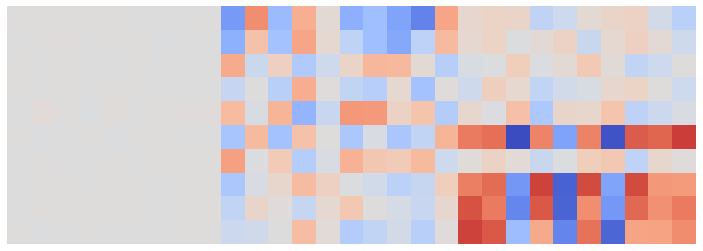

In [26]:
from matplotlib import cm as mpl_colormaps
from common.utils import CenteredNorm
import matplotlib.pyplot as plt 

Ws = [vae_experiment.model.prior_gnn[i].projection.weight.detach() for i in range(3)]
Ws_to_plot = torch.cat(Ws, dim = 1).numpy()
print(Ws_to_plot.shape)
fig, axs = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=0)
axs.margins(0)
plt.axis('off')
plt.imshow(Ws_to_plot, cmap=mpl_colormaps.coolwarm, norm=CenteredNorm())

(10, 29)


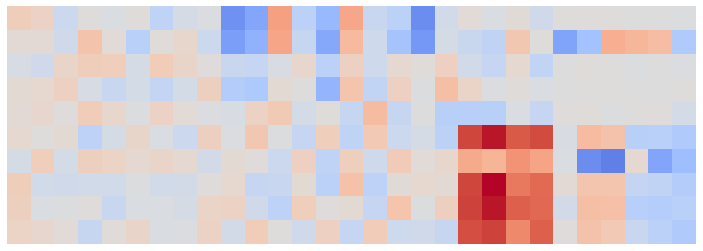

In [27]:
Ws = [vae_experiment.model.encoder_gnn[i].projection.weight.detach() for i in range(3)]
Ws_to_plot = torch.cat(Ws, dim = 1).numpy()
print(Ws_to_plot.shape)
fig, axs = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=0)
axs.margins(0)
plt.axis('off')
plt.imshow(Ws_to_plot, cmap=mpl_colormaps.coolwarm, norm=CenteredNorm())

In [28]:
 [vae_experiment.model.prior_gnn[i].projection.weight.size() for i in range(3)]

[torch.Size([10, 9]), torch.Size([10, 10]), torch.Size([10, 10])]

# For the 2D node feat dim model

(4, 17)
(4, 17)


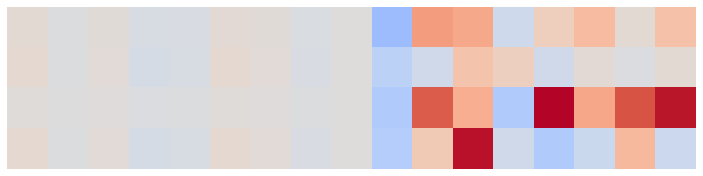

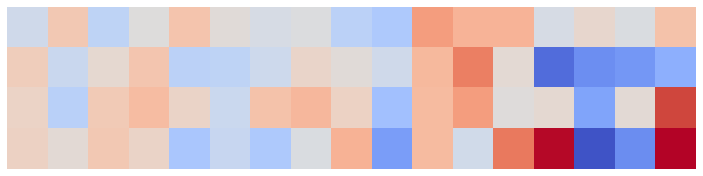

In [32]:
Ws = [vae_experiment.model.prior_gnn[i].projection.weight.detach() for i in range(3)]
Ws_to_plot = torch.cat(Ws, dim = 1).numpy()
print(Ws_to_plot.shape)
fig, axs = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=0)
axs.margins(0)
plt.axis('off')
plt.imshow(Ws_to_plot, cmap=mpl_colormaps.coolwarm, norm=CenteredNorm())

Ws = [vae_experiment.model.encoder_gnn[i].projection.weight.detach() for i in range(3)]
Ws_to_plot = torch.cat(Ws, dim = 1).numpy()
print(Ws_to_plot.shape)
fig, axs = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=0)
axs.margins(0)
plt.axis('off')
plt.imshow(Ws_to_plot, cmap=mpl_colormaps.coolwarm, norm=CenteredNorm())